# CNN on MRNet data set

mount drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
#change directory to folder holding the data
os.chdir('/content/gdrive/My Drive/MR_dataset')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

In [0]:
main_dir = "MRNet-v1.0"

load data of a specific scan from sub directory(train or valid) for each scan type(axial, coronal, sagittal) and return a numpy array of shape  256 x256x3  a three random slices of the MRI to feed them to the 3 channel CNN

In [0]:
def load_scan_series(directory, sub_directory, scanType, scan_ID):
    id = str(scan_ID)
    #add zeros prefix
    if len(id) < 4:
        for n in range(4 - len(id)):
            id = "0" + id
    mri = np.load(directory + "/" + sub_directory + "/" + scanType + "/" + id + ".npy")
    rgb_img =[]
    s = int(mri.shape[0]/2)
    rgb_img.append(mri[s,:,:])
    rgb_img.append(mri[s,:,:])
    rgb_img.append(mri[s,:,:])
    rgb_img=np.array(rgb_img)
    rgb_img=np.moveaxis(rgb_img, -1, 0)
    rgb_img=np.moveaxis(rgb_img, -1, 0)
    rgb_img = np.array(rgb_img)
    return rgb_img

create a numpy array of series of images of a certain scan type each series is  256 x 256x3 

In [0]:
def scan_series_Array(directory, subset, scanType, num_samples, start):
    data = []
    label =[]
    start2 = 0
    if subset == "valid":
      start2 =start+ 1130
    for n in range (num_samples):
        mri = load_scan_series(directory, subset, scanType,n+ start2)
        data.append(np.array(mri))
    #data = np.vstack(data)
    data = np.array(data)
    return data

include the Fscore metric from sklearn by creating a custom metric class and a function to be called on each epoch end

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [0]:
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
 

  def on_epoch_end(self, epoch, logs={}):
    X_val, y_val = self.validation_data[0], self.validation_data[1]
    y_predict = np.asarray(acl_sagittal_model.predict(X_val))
    
    _val_f1 = f1_score(y_val, y_predict.round())
    
    self.val_f1s.append(_val_f1)
    print("— val_f1: " + str(_val_f1))
    return
  
  def get_data(self):
    return self.val_f1s

 create an instance of the cass metrics to pass it as an argument for the model

In [0]:
#first layer:
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers import Input, Flatten, Dense
from keras.layers.convolutional import Conv2D


In [0]:
from keras.applications import resnet50, vgg16

using our base model as the vgg 16

In [0]:
import numpy as np

base_model = vgg16.VGG16(weights='imagenet',
                               input_shape=(256,256,3),include_top=False) 
#imports the mobilenet model and discards the last 1000 neuron layer.
for layer in base_model.layers:
  layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
from keras.layers import Dense,GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

x=base_model.output
x=GlobalAveragePooling2D()(x)
#x=Dense(256,activation='relu')(x) 
#x=x=Dropout(0.3)(x)
#x=Dense(100,activation='relu')(x) 
#x=x=Dropout(0.3)(x)
x=Dense(100,activation='relu')(x) 
#x=x=Dropout(0.3)(x)
preds=Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation (because a sigmoid exists between zero and one)

# **abnormal axial**

Get the abnormal train labels

In [0]:
train_abnormal_labels = pd.read_csv(main_dir+'/' + "train-abnormal.csv", header=None)[1].values

get the abnormal axial training data

In [0]:
train_axial= scan_series_Array(main_dir,"train", "axial", 1130, 0)

creating the abnormal axial model

In [0]:
abnormal_axial_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
abnormal_axial_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

  ModelCheckpoint(filepath='content/gdrive/My Drive/MR_dataset/bestModel.h5'
  
  from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3),#patience->unchanged epoches tolerated,
             (monitor='val_loss'),save_best_only=True,metrics)

In [0]:
metrics = Metrics()

In [0]:
abnormal_axial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
import gc
gc.collect()

0

In [0]:
history=abnormal_axial_model.fit(train_axial, train_abnormal_labels, epochs = 20,
                  shuffle=True, verbose = 1, validation_split=0.02,callbacks=[metrics])

save the model

In [0]:
abnormal_axial_model.save_weights('abnormal_axial_weights.h5') #load best weights

get accuracy and f score

In [0]:
axial_abnormal_train_acc = history.history['acc']
axial_abnormal_train_loss = history.history['loss']
axial_abnormal_train_fscore = metrics.get_data()

plot metrics

Accuracy

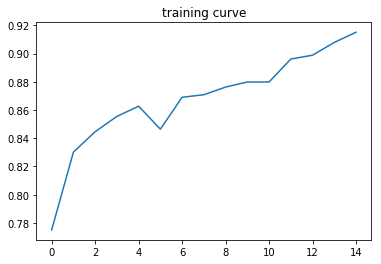

In [0]:
plt.plot(axial_abnormal_train_acc)
plt.title('training curve')
plt.show()

loss

Text(0.5, 1.0, 'training curve')

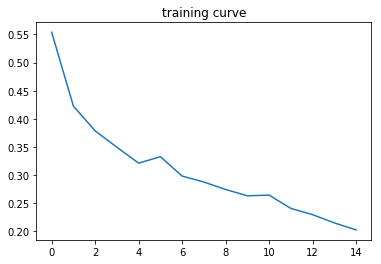

In [0]:
plt.plot(axial_abnormal_train_loss)
plt.title('training curve')

fscore


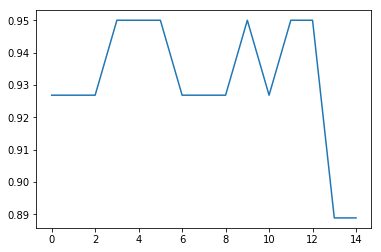

In [0]:
plt.plot(axial_abnormal_train_fscore)

load the validation abnormal labels

In [0]:
valid_abnormal_labels = pd.read_csv(main_dir+'/' + "valid-abnormal.csv", header=None)[1].values

load the validation axial data

In [0]:
valid_axial = scan_series_Array(main_dir,"valid", "axial", 120, 0)

In [0]:
valid_axial.shape

(120, 256, 256, 3)

In [0]:
score=abnormal_axial_model.evaluate(valid_axial,valid_abnormal_labels)
print (score)
print(abnormal_axial_model.metrics_names)

120/120 [==============================] - 3s 27ms/step
[0.3659030372897784, 0.8583333293596903]
['loss', 'acc']


save abnormal axial model predictions

In [0]:
abnormal_axial_model.load_weights('abnormal_axial_weights.h5')

In [0]:
axial_abnormal_prediction=abnormal_axial_model.predict(valid_axial)
np.save('axial_abnormal_prediction',axial_abnormal_prediction)

# **abnormal coronal**



get the abnormal axial training data

In [0]:
train_coronal= scan_series_Array(main_dir,"train", "coronal", 1130, 0)

create the model

In [0]:
abnormal_coronal_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
abnormal_coronal_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
import gc
gc.collect()

0

 create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_ab_cor = Metrics()

In [0]:
history4=abnormal_coronal_model.fit(train_coronal, train_abnormal_labels, epochs = 20,
                  shuffle=True, verbose = 1, validation_split=0.02,callbacks=[metrics_ab_cor])

Instructions for updating:
Use tf.cast instead.
Train on 1107 samples, validate on 23 samples
Epoch 1/20
1107/1107 [==============================] - 12s 11ms/step - loss: 0.4940 - acc: 0.7895 - val_loss: 0.4669 - val_acc: 0.7826
— val_f1: 0.8780487804878049
Epoch 2/20
1107/1107 [==============================] - 7s 7ms/step - loss: 0.4396 - acc: 0.8076 - val_loss: 0.4401 - val_acc: 0.8261
— val_f1: 0.9047619047619047
Epoch 3/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.4066 - acc: 0.8148 - val_loss: 0.4025 - val_acc: 0.7826
— val_f1: 0.8780487804878049
Epoch 4/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3852 - acc: 0.8248 - val_loss: 0.3954 - val_acc: 0.8261
— val_f1: 0.9047619047619047
Epoch 5/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3739 - acc: 0.8311 - val_loss: 0.3993 - val_acc: 0.7391
— val_f1: 0.8421052631578947
Epoch 6/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3615 - acc:

save the model

In [0]:
abnormal_coronal_model.save_weights('abnormal_coronal_weights.h5') #load best weights

get accuracy and f score

In [0]:
coronal_abnormal_train_acc = history4.history['acc']
coronal_abnormal_train_loss = history4.history['loss']
coronal_abnormal_train_fscore = metrics_ab_cor.get_data()

plot metrics

Accuracy

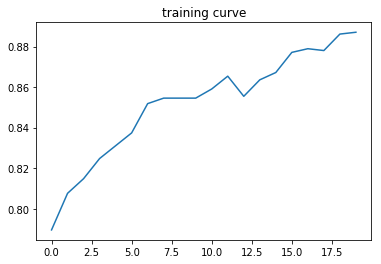

In [0]:
plt.plot(coronal_abnormal_train_acc)
plt.title('training curve')
plt.show()

loss

Text(0.5, 1.0, 'training curve')

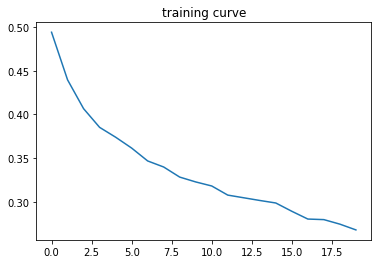

In [0]:
plt.plot(coronal_abnormal_train_loss)
plt.title('training curve')

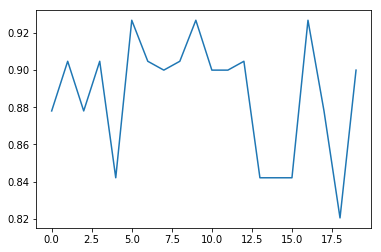

In [0]:
plt.plot(coronal_abnormal_train_fscore)

load the validation abnormal labels

In [0]:
valid_abnormal_labels = pd.read_csv(main_dir+'/' + "valid-abnormal.csv", header=None)[1].values

load the validation axial data

In [0]:
valid_coronal = scan_series_Array(main_dir,"valid", "coronal", 120, 0)

In [0]:
ab_cor_score=abnormal_coronal_model.evaluate(valid_coronal,valid_abnormal_labels)
print (ab_cor_score)
print(abnormal_coronal_model.metrics_names)

120/120 [==============================] - 1s 7ms/step
[0.4410544956723849, 0.8333333373069763]
['loss', 'acc']


load weights directly

In [0]:
abnormal_coronal_model.load_weights('abnormal_coronal_weights.h5')

save abnormal axial model predictions

In [0]:
coronal_abnormal_prediction=abnormal_coronal_model.predict(valid_coronal)
np.save('coronal_abnormal_prediction',coronal_abnormal_prediction)

# **abnormal sagittal**



get the abnormal sagittal training data

In [0]:
train_sagittal= scan_series_Array(main_dir,"train", "sagittal", 1130, 0)

create the model

In [0]:
abnormal_sagittal_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
abnormal_sagittal_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
import gc
gc.collect()

85

 create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_ab_sag = Metrics()

In [0]:
history8=abnormal_sagittal_model.fit(train_sagittal, train_abnormal_labels, epochs = 20,
                  shuffle=True, verbose = 1,batch_size=32, validation_split=0.02,callbacks=[metrics_ab_sag])

Train on 1107 samples, validate on 23 samples
Epoch 1/20
1107/1107 [==============================] - 8s 7ms/step - loss: 1.1534 - acc: 0.7236 - val_loss: 0.7641 - val_acc: 0.7826
— val_f1: 0.8780487804878049
Epoch 2/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.4993 - acc: 0.7958 - val_loss: 0.4872 - val_acc: 0.8261
— val_f1: 0.9
Epoch 3/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3989 - acc: 0.8229 - val_loss: 0.4401 - val_acc: 0.7826
— val_f1: 0.8717948717948718
Epoch 4/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3834 - acc: 0.8320 - val_loss: 0.4306 - val_acc: 0.8696
— val_f1: 0.918918918918919
Epoch 5/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3843 - acc: 0.8275 - val_loss: 0.3539 - val_acc: 0.8261
— val_f1: 0.8947368421052632
Epoch 6/20
1107/1107 [==============================] - 8s 7ms/step - loss: 0.2940 - acc: 0.8663 - val_loss: 0.3047 - val_acc: 0.7826
— val_f1: 0.871794871

save the model

In [0]:
abnormal_sagittal_model.save_weights('abnormal_sagittal_weights.h5') #load best weights

get accuracy and f score

In [0]:
sagittal_abnormal_train_acc = history8.history['acc']
sagittal_abnormal_train_loss = history8.history['loss']
sagittal_abnormal_train_fscore = metrics_ab_sag.get_data()

plot metrics

Accuracy

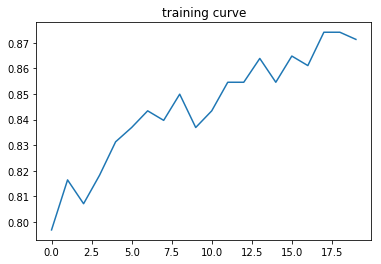

In [0]:
plt.plot(sagittal_abnormal_train_acc)
plt.title('training curve')
plt.show()

loss

Text(0.5, 1.0, 'loss')

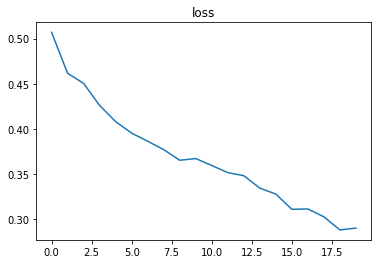

In [0]:
plt.plot(sagittal_abnormal_train_loss)
plt.title('loss')

Text(0.5, 1.0, 'fscore')

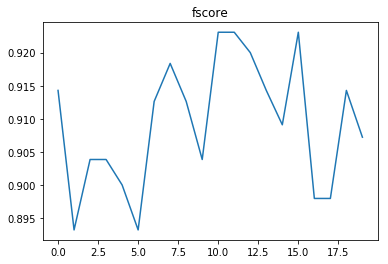

In [0]:
plt.plot(sagittal_abnormal_train_fscore)
plt.title('fscore')

load the validation abnormal labels

In [0]:
valid_abnormal_labels = pd.read_csv(main_dir+'/' + "valid-abnormal.csv", header=None)[1].values

load the validation axial data

In [0]:
valid_sagittal = scan_series_Array(main_dir,"valid", "sagittal", 120, 0)

In [0]:
sagittal_cor_score=abnormal_sagittal_model.evaluate(valid_sagittal,valid_abnormal_labels)
print (sagittal_cor_score)
print(abnormal_sagittal_model.metrics_names)

120/120 [==============================] - 2s 13ms/step
[0.4598346143960953, 0.825]
['loss', 'acc']


load weights directly

In [0]:
abnormal_sagittal_model.load_weights('abnormal_sagittal_weights.h5')

save abnormal axial model predictions

In [0]:
sagittal_abnormal_prediction=abnormal_sagittal_model.predict(valid_sagittal)
np.save('sagittal_abnormal_prediction',sagittal_abnormal_prediction)

In [0]:
sagittal_abnormal_prediction.round()

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

# **acl axial model**





In [0]:
from collections import Counter 
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}
  
class_weights=get_class_weights(train_acl_labels)

print(class_weights)

{0: 1.0, 1: 4.4326923076923075}


load the acl train labels

In [0]:
train_acl_labels = pd.read_csv(main_dir+'/' + "train-acl.csv", header=None)[1].values

create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_acl_ax = Metrics()

create the axial acl model

In [0]:
acl_axial_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
acl_axial_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
import gc
gc.collect()

161

In [0]:
history2=acl_axial_model.fit(train_axial, train_acl_labels, epochs = 15,
                  shuffle=True, verbose = 1, validation_split=0.02,callbacks=[metrics_acl_ax])

save the model

100 dense

In [0]:
acl_axial_model.save_weights('acl_axial_weights.h5') #load best weights

plot metrics

In [0]:
axial_acl_train_acc = history2.history['acc']
axial_acl_train_loss = history2.history['loss']
axial_acl_train_fscore = metrics_acl_ax.get_data()

accuracy:

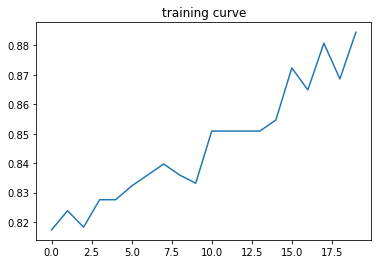

In [0]:
plt.plot(axial_acl_train_acc)
plt.title('training curve')
plt.show()

loss

Text(0.5, 1.0, 'training curve')

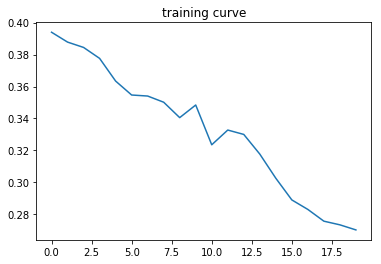

In [0]:
plt.plot(axial_acl_train_loss)
plt.title('training curve')

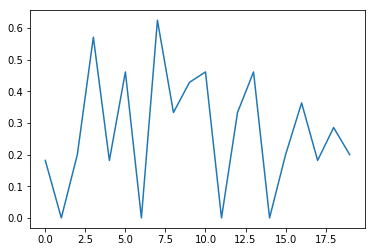

In [0]:
plt.plot(axial_acl_train_fscore)

load the validation abnormal labels

In [0]:
valid_acl_labels = pd.read_csv(main_dir+'/' + "valid-acl.csv", header=None)[1].values

load the saved weights

In [0]:
acl_axial_model.load_weights('acl_axial_weights.h5')

validate

In [0]:
acl_axial_score=acl_axial_model.evaluate(valid_axial,valid_acl_labels)
print (acl_axial_score)
print(acl_axial_model.metrics_names)

120/120 [==============================] - 2s 14ms/step
[1.6628428419431052, 0.7083333333333334]
['loss', 'acc']


save the axial acl model predictions

In [0]:
axial_acl_prediction=acl_axial_model.predict(valid_axial)
np.save('axial_acl_prediction',axial_acl_prediction)

In [0]:
axial_acl_prediction.round()

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],

# **acl coronal**

create the model

In [0]:
acl_coronal_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
acl_coronal_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
acl_coronal_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
import gc
gc.collect()

0

create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_acl_cor = Metrics()

In [0]:
history5=acl_coronal_model.fit(train_coronal, train_acl_labels, epochs = 50,
                  shuffle=True, class_weight={0: 1.0, 1: 2.0}, verbose = 1, 
                  batch_size=100,validation_split=0.05,callbacks=[metrics_acl_cor])

Train on 1073 samples, validate on 57 samples
Epoch 1/50
1073/1073 [==============================] - 9s 8ms/step - loss: 0.6170 - acc: 0.8117 - val_loss: 0.7152 - val_acc: 0.8421
— val_f1: 0.47058823529411764
Epoch 2/50
1073/1073 [==============================] - 8s 8ms/step - loss: 0.3742 - acc: 0.8816 - val_loss: 0.7711 - val_acc: 0.8246
— val_f1: 0.4444444444444444
Epoch 3/50
1073/1073 [==============================] - 8s 8ms/step - loss: 0.3566 - acc: 0.8910 - val_loss: 0.7582 - val_acc: 0.7544
— val_f1: 0.46153846153846156
Epoch 4/50
1073/1073 [==============================] - 8s 8ms/step - loss: 0.3248 - acc: 0.8966 - val_loss: 0.7878 - val_acc: 0.8596
— val_f1: 0.5555555555555556
Epoch 5/50
1073/1073 [==============================] - 8s 7ms/step - loss: 0.2866 - acc: 0.9077 - val_loss: 0.9335 - val_acc: 0.7719
— val_f1: 0.380952380952381
Epoch 6/50
1073/1073 [==============================] - 8s 7ms/step - loss: 0.2458 - acc: 0.9254 - val_loss: 0.8509 - val_acc: 0.7895
— va

save the model

In [0]:
acl_coronal_model.save_weights('acl_coronal_weights.h5') #load best weights

get accuracy and f score

In [0]:
coronal_acl_train_acc = history5.history['acc']
coronal_acl_train_loss = history5.history['loss']
coronal_acl_train_fscore = metrics_acl_cor.get_data()

plot metrics

Accuracy

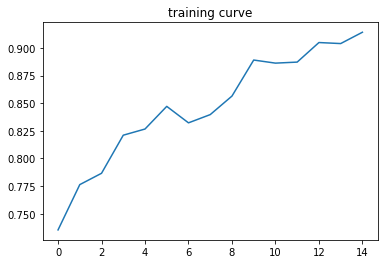

In [0]:
plt.plot(coronal_acl_train_acc)
plt.title('training curve')
plt.show()

loss

Text(0.5, 1.0, 'training curve')

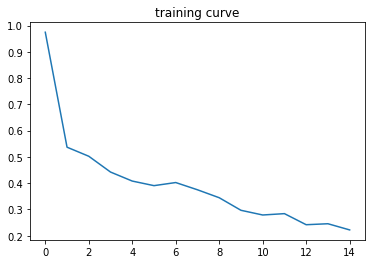

In [0]:
plt.plot(coronal_acl_train_loss)
plt.title('training curve')

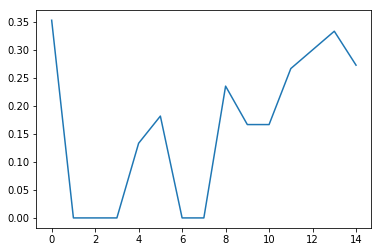

In [0]:
plt.plot(coronal_acl_train_fscore)

load the validation acl labels

In [0]:
valid_acl_labels = pd.read_csv(main_dir+'/' + "valid-acl.csv", header=None)[1].values

load the validation coronal data

In [0]:
valid_coronal = scan_series_Array(main_dir,"valid", "coronal", 120, 0)

In [0]:
acl_cor_score=acl_coronal_model.evaluate(valid_coronal,valid_acl_labels)
print (acl_cor_score)
print(acl_coronal_model.metrics_names)

120/120 [==============================] - 8s 65ms/step
[0.950196361541748, 0.7166666706403096]
['loss', 'acc']


save acl coronal model predictions

In [0]:
acl_coronal_model.load_weights('acl_coronal_weights.h5')

In [0]:
coronal_acl_prediction=acl_coronal_model.predict(valid_coronal)
np.save('coronal_acl_prediction',coronal_acl_prediction)

# **acl sagittal**



create the model

In [0]:
acl_sagittal_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
acl_sagittal_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
import gc
gc.collect()

139

 create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_acl_sag = Metrics()

In [0]:
history9=acl_sagittal_model.fit(train_sagittal, train_acl_labels, epochs = 10,
                  shuffle=True, verbose = 1, validation_split=0.02,callbacks=[metrics_acl_sag])

Train on 1107 samples, validate on 23 samples
Epoch 1/10
1107/1107 [==============================] - 8s 7ms/step - loss: 0.5572 - acc: 0.7841 - val_loss: 0.2978 - val_acc: 0.8696


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


— val_f1: 0.0
Epoch 2/10
1107/1107 [==============================] - 7s 7ms/step - loss: 0.4168 - acc: 0.8166 - val_loss: 0.2766 - val_acc: 0.8696
— val_f1: 0.0
Epoch 3/10
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3543 - acc: 0.8446 - val_loss: 0.2988 - val_acc: 0.8696
— val_f1: 0.0
Epoch 4/10
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3339 - acc: 0.8546 - val_loss: 0.3148 - val_acc: 0.8696
— val_f1: 0.0
Epoch 5/10
1107/1107 [==============================] - 8s 7ms/step - loss: 0.3248 - acc: 0.8573 - val_loss: 0.3245 - val_acc: 0.8261
— val_f1: 0.0
Epoch 6/10
1107/1107 [==============================] - 7s 7ms/step - loss: 0.2907 - acc: 0.8790 - val_loss: 0.2899 - val_acc: 0.9130
— val_f1: 0.5
Epoch 7/10
1107/1107 [==============================] - 7s 7ms/step - loss: 0.2797 - acc: 0.8753 - val_loss: 0.2882 - val_acc: 0.8696
— val_f1: 0.0
Epoch 8/10
1107/1107 [==============================] - 7s 7ms/step - loss: 0.2514 - acc: 0.8988 -

save the model

In [0]:
acl_sagittal_model.save_weights('acl_sagittal_weights.h5') #load best weights

get accuracy and f score

In [0]:
sagittal_acl_train_acc = history9.history['acc']
sagittal_acl_train_loss = history9.history['loss']
sagittal_acl_train_fscore = metrics_acl_sag.get_data()

plot metrics

Accuracy

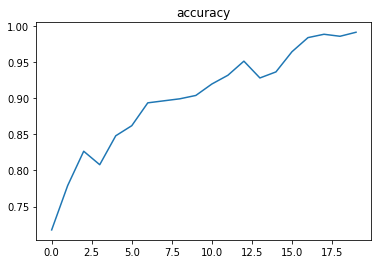

In [0]:
plt.plot(sagittal_acl_train_acc)
plt.title('accuracy')
plt.show()

loss

Text(0.5, 1.0, 'loss')

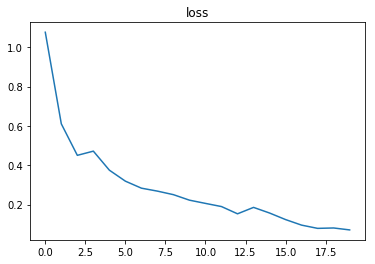

In [0]:
plt.plot(sagittal_acl_train_loss)
plt.title('loss')

Text(0.5, 1.0, 'fscore')

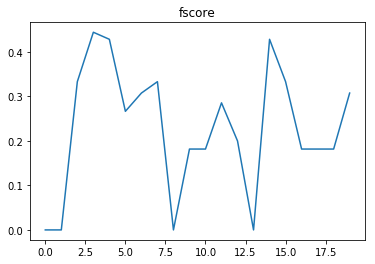

In [0]:
plt.plot(sagittal_acl_train_fscore)
plt.title('fscore')

load the validation abnormal labels

In [0]:
valid_acl_labels = pd.read_csv(main_dir+'/' + "valid-acl.csv", header=None)[1].values

load the validation axial data

In [0]:
valid_sagittal = scan_series_Array(main_dir,"valid", "sagittal", 120, 0)

In [0]:
acl_sagittal_score=acl_sagittal_model.evaluate(valid_sagittal,valid_acl_labels)
print (acl_sagittal_score)
print(acl_sagittal_model.metrics_names)

120/120 [==============================] - 2s 14ms/step
[1.2267017563184102, 0.6833333373069763]
['loss', 'acc']


load weights directly

In [0]:
acl_sagittal_model.load_weights('acl_sagittal_weights.h5')

save abnormal axial model predictions

In [0]:
sagittal_acl_prediction=acl_sagittal_model.predict(valid_sagittal)
np.save('sagittal_acl_prediction',sagittal_acl_prediction)

# **meniscus axial**

load meniscus train labels

In [0]:
train_meniscus_labels = pd.read_csv(main_dir+'/' + "train-meniscus.csv", header=None)[1].values

create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_meniscus_ax = Metrics()

create the meniscus axial model

In [0]:
meniscus_axial_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
meniscus_axial_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
import gc
gc.collect()

2562

In [0]:
history3=meniscus_axial_model.fit(train_axial, train_meniscus_labels, epochs =15,
                  shuffle=True, verbose = 1,validation_split=0.05,callbacks=[metrics_meniscus_ax])

Train on 1073 samples, validate on 57 samples
Epoch 1/15
1073/1073 [==============================] - 8s 7ms/step - loss: 0.9827 - acc: 0.6934 - val_loss: 1.0724 - val_acc: 0.6491
— val_f1: 0.6428571428571428
Epoch 2/15
1073/1073 [==============================] - 8s 7ms/step - loss: 0.5822 - acc: 0.7521 - val_loss: 0.6341 - val_acc: 0.7018
— val_f1: 0.6382978723404256
Epoch 3/15
1073/1073 [==============================] - 8s 7ms/step - loss: 0.4382 - acc: 0.7959 - val_loss: 0.6102 - val_acc: 0.7018
— val_f1: 0.5853658536585366
Epoch 4/15
1073/1073 [==============================] - 8s 7ms/step - loss: 0.3558 - acc: 0.8406 - val_loss: 0.6089 - val_acc: 0.6842
— val_f1: 0.5909090909090909
Epoch 5/15
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3677 - acc: 0.8378 - val_loss: 0.8371 - val_acc: 0.6842
— val_f1: 0.6666666666666666
Epoch 6/15
1073/1073 [==============================] - 7s 7ms/step - loss: 0.3530 - acc: 0.8425 - val_loss: 0.6145 - val_acc: 0.7368
— val

save the model

In [0]:
meniscus_axial_model.save_weights('meniscus_axial_weights.h5') #load best weights

In [0]:
axial_meniscus_train_acc = history3.history['acc']
axial_meniscus_train_loss = history3.history['loss']
axial_meniscus_train_fscore = metrics_meniscus_ax.get_data()

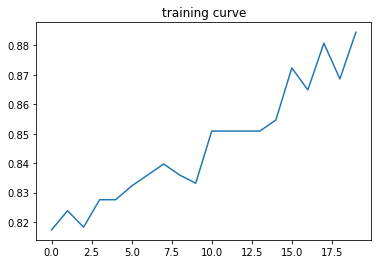

In [0]:
plt.plot(axial_acl_train_acc)
plt.title('training curve')
plt.show()

loss

Text(0.5, 1.0, 'training curve')

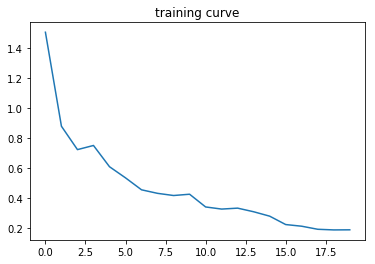

In [0]:
plt.plot(axial_meniscus_train_loss)
plt.title('training curve')

fscore

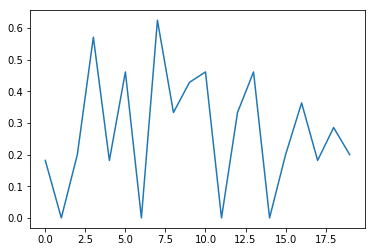

In [0]:
plt.plot(axial_acl_train_fscore)

load the validation meniscus labels

In [0]:
valid_meniscus_labels = pd.read_csv(main_dir+'/' + "valid-meniscus.csv", header=None)[1].values

load weights directly

In [0]:
meniscus_axial_model.load_weights('meniscus_axial_weights.h5')

validate

In [0]:
meniscus_axial_score=meniscus_axial_model.evaluate(valid_axial,valid_meniscus_labels)
print (meniscus_axial_score)
print(meniscus_axial_model.metrics_names)

120/120 [==============================] - 2s 13ms/step
[1.0923907597859701, 0.6083333313465118]
['loss', 'acc']


save th predictions of the axial meniscus model

In [0]:
axial_meniscus_prediction =meniscus_axial_model.predict(valid_axial,verbose=1)
np.save('axial_meniscus_prediction',axial_meniscus_prediction)

120/120 [==============================] - 2s 13ms/step


# **meniscus coronal**

create the model

In [0]:
meniscus_coronal_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
meniscus_coronal_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
import gc
gc.collect()

139

create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_meniscus_cor = Metrics()

In [0]:
history7=meniscus_coronal_model.fit(train_coronal, train_meniscus_labels, epochs = 15,
                  shuffle=True, verbose = 1, validation_split=0.02,callbacks=[metrics_meniscus_cor])

Train on 1107 samples, validate on 23 samples
Epoch 1/15
1107/1107 [==============================] - 12s 11ms/step - loss: 0.9608 - acc: 0.6089 - val_loss: 0.5808 - val_acc: 0.6087
— val_f1: 0.5714285714285713
Epoch 2/15
1107/1107 [==============================] - 8s 7ms/step - loss: 0.6818 - acc: 0.6694 - val_loss: 0.5516 - val_acc: 0.6957
— val_f1: 0.588235294117647
Epoch 3/15
1107/1107 [==============================] - 8s 7ms/step - loss: 0.5892 - acc: 0.7001 - val_loss: 0.5429 - val_acc: 0.6522
— val_f1: 0.5555555555555556
Epoch 4/15
1107/1107 [==============================] - 8s 7ms/step - loss: 0.5376 - acc: 0.7272 - val_loss: 0.5859 - val_acc: 0.6957
— val_f1: 0.6666666666666666
Epoch 5/15
1107/1107 [==============================] - 7s 7ms/step - loss: 0.5495 - acc: 0.7353 - val_loss: 0.5643 - val_acc: 0.6957
— val_f1: 0.588235294117647
Epoch 6/15
1107/1107 [==============================] - 7s 7ms/step - loss: 0.5088 - acc: 0.7462 - val_loss: 0.5875 - val_acc: 0.6957
— val

save the model

In [0]:
meniscus_coronal_model.save_weights('meniscus_coronal_weights.h5') #load best weights

get accuracy and f score

In [0]:
coronal_meniscus_train_acc = history7.history['acc']
coronal_meniscus_train_loss = history7.history['loss']
coronal_meniscus_train_fscore = metrics_meniscus_cor.get_data()

plot metrics

Accuracy

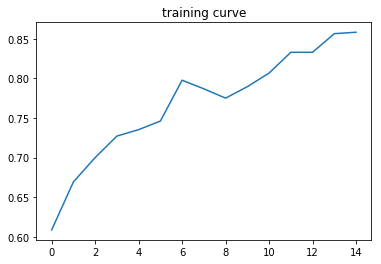

In [0]:
plt.plot(coronal_meniscus_train_acc)
plt.title('training curve')
plt.show()

loss

Text(0.5, 1.0, 'training curve')

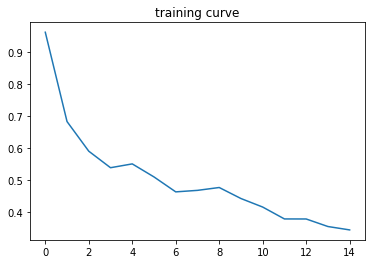

In [0]:
plt.plot(coronal_meniscus_train_loss)
plt.title('training curve')

fscore

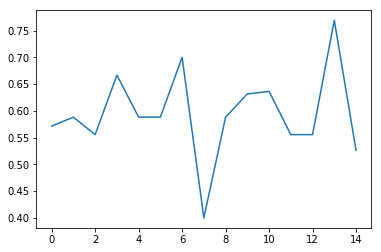

In [0]:
plt.plot(coronal_meniscus_train_fscore)

load the validation acl labels

In [0]:
valid_meniscus_labels = pd.read_csv(main_dir+'/' + "valid-meniscus.csv", header=None)[1].values

load the validation coronal data

In [0]:
valid_coronal = scan_series_Array(main_dir,"valid", "coronal", 120, 0)

In [0]:
meniscus_cor_score=meniscus_coronal_model.evaluate(valid_coronal,valid_meniscus_labels)
print (meniscus_cor_score)
print(meniscus_coronal_model.metrics_names)

120/120 [==============================] - 1s 7ms/step
[0.7857162714004516, 0.700000003973643]
['loss', 'acc']


load weights directly

In [0]:
meniscus_coronal_model.load_weights('acl_coronal_weights.h5')

save acl coronal model predictions

In [0]:
coronal_meniscus_prediction=meniscus_coronal_model.predict(valid_coronal)
np.save('coronal_meniscus_prediction',coronal_meniscus_prediction)

validation metrics plots

In [0]:
coronal_meniscus_val_acc=history7.history['val_acc']

In [0]:
coronal_meniscus_val_loss=history7.history['val_loss']

Text(0.5, 1.0, 'validation accuracy')

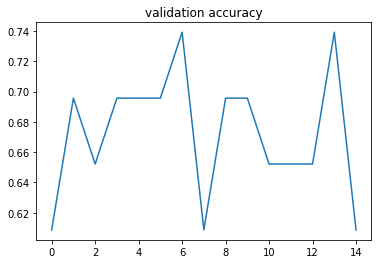

In [0]:
plt.plot(coronal_meniscus_val_acc)
plt.title('validation accuracy')

Text(0.5, 1.0, 'validation loss')

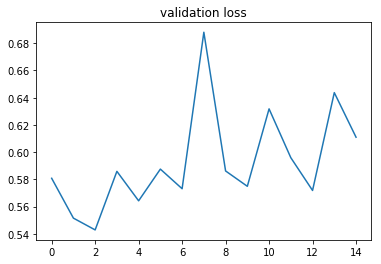

In [0]:
plt.plot(coronal_meniscus_val_loss)
plt.title('validation loss')

# **meniscus sagittal**



create the model

In [0]:
meniscus_sagittal_model=Model(inputs=base_model.input,outputs=preds)

In [0]:
#compile
meniscus_sagittal_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
import gc
gc.collect()

98

 create an instance of the cass metrics to pass it as an argument for the model

In [0]:
metrics_meniscus_sag = Metrics()

In [0]:
history1=meniscus_sagittal_model.fit(train_sagittal, train_meniscus_labels, epochs = 2,
                  shuffle=True, verbose = 1, validation_split=0.02,callbacks=[metrics_meniscus_sag])

save the model

In [0]:
meniscus_sagittal_model.save_weights('meniscus_sagittal_weights.h5') #load best weights

get accuracy and f score

In [0]:
sagittal_meniscus_train_acc = history1.history['acc']
sagittal_meniscus_train_loss = history1.history['loss']
sagittal_meniscus_train_fscore = metrics_meniscus_sag.get_data()

plot metrics

Accuracy

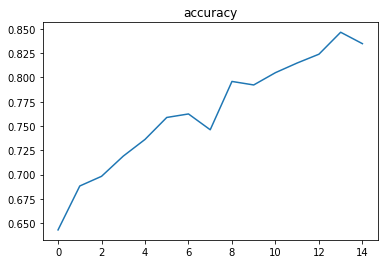

In [0]:
plt.plot(sagittal_meniscus_train_acc)
plt.title('accuracy')
plt.show()

loss

Text(0.5, 1.0, 'loss')

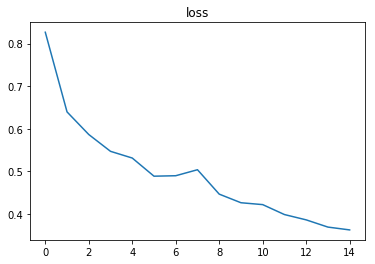

In [0]:
plt.plot(sagittal_meniscus_train_loss)
plt.title('loss')

Text(0.5, 1.0, 'fscore')

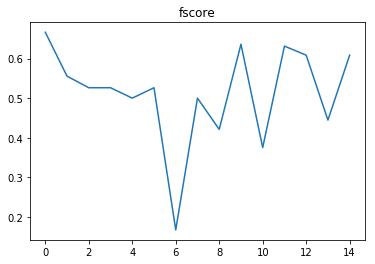

In [0]:
plt.plot(sagittal_meniscus_train_fscore)
plt.title('fscore')

load the validation meniscus labels

In [0]:
valid_meniscus_labels = pd.read_csv(main_dir+'/' + "valid-meniscus.csv", header=None)[1].values

load the validation sagittal data

In [0]:
valid_sagittal = scan_series_Array(main_dir,"valid", "sagittal", 120, 0)

In [0]:
meniscus_sagittal_score=meniscus_sagittal_model.evaluate(valid_sagittal,valid_meniscus_labels)
print (meniscus_sagittal_score)
print(meniscus_sagittal_model.metrics_names)

120/120 [==============================] - 1s 7ms/step
[0.7196163177490235, 0.749999996026357]
['loss', 'acc']


load weights directly

In [0]:
meniscus_sagittal_model.load_weights('meniscus_sagittal_weights.h5')

save abnormal axial model predictions

In [0]:
sagittal_meniscus_prediction=meniscus_sagittal_model.predict(valid_sagittal)
np.save('sagittal_meniscus_prediction',sagittal_meniscus_prediction)

# **Ensemble the three classifiers**

**Abnormal final predictions and accuracy**

In [0]:
from sklearn.metrics import accuracy_score

load the saved predictions

In [0]:
pred1 = np.load('axial_abnormal_prediction.npy')
pred2 = np.load('coronal_abnormal_prediction.npy')
pred3 = np.load('sagittal_abnormal_prediction.npy')

weighted average

In [0]:
abnormal_final_pred = (pred1*0.8+pred2*0.1+pred2*0.1).round()

or majority voting

In [0]:
abnormal_final_pred2 = pred1+pred2+pred3
abnormal_final_pred2[abnormal_final_pred2<2] = 0
abnormal_final_pred2[abnormal_final_pred2>=2] = 1

calculate final abnormal accuracy

avg weighted accuracy

In [0]:
abnormal_final_score1 = accuracy_score(valid_abnormal_labels,abnormal_final_pred)
abnormal_final_score1

0.8

majority voting

In [0]:
abnormal_final_score2 = accuracy_score(valid_abnormal_labels,abnormal_final_pred2)
abnormal_final_score2

0.825

averaging

In [0]:
abnormal_final_pred3 = ((pred1+pred2+pred3)/3).round()
abnormal_final_score3 = accuracy_score(valid_abnormal_labels,abnormal_final_pred3)
abnormal_final_score3

0.825

**Acl final predictions and accuracy**

load the saved predictions

In [0]:
pred1_acl = np.load('axial_acl_prediction.npy')
pred2_acl = np.load('coronal_acl_prediction.npy')
pred3_acl = np.load('sagittal_acl_prediction.npy')

weighted average

In [0]:
acl_final_pred = (pred1_acl*0.3+pred2_acl*0.4+pred2_acl*0.3).round()

or majority voting

In [0]:
acl_final_pred2 = pred1_acl+pred2_acl+pred3_acl
acl_final_pred2[acl_final_pred2<2] = 0
acl_final_pred2[acl_final_pred2>=2] = 1

calculate final acl accuracy

avg weighted accuracy

In [0]:
acl_final_score1 = accuracy_score(valid_acl_labels,acl_final_pred)
acl_final_score1

0.75

majority voting

In [0]:
acl_final_score2 = accuracy_score(valid_acl_labels,acl_final_pred2)
acl_final_score2

0.625

averaging

In [0]:
acl_final_pred3 = ((pred1_acl+pred2_acl+pred3_acl)/3).round()

In [0]:
acl_final_score3 = accuracy_score(valid_meniscus_labels,acl_final_pred3)
acl_final_score3

0.6083333333333333

 **meniscus final predictions and accuracy**

load the saved predictions

In [0]:
pred1_m = np.load('axial_meniscus_prediction.npy')
pred2_m = np.load('coronal_meniscus_prediction.npy')
pred3_m = np.load('sagittal_meniscus_prediction.npy')

weighted average

In [0]:
meniscus_final_pred = (pred1_m*0.1+pred2_m*0.4+pred2_m*0.5).round()

or majority voting

In [0]:
meniscus_final_pred2 = pred1_m+pred2_m+pred3_m
meniscus_final_pred2[meniscus_final_pred2<2] = 0
meniscus_final_pred2[meniscus_final_pred2>=2] = 1

calculate final acl accuracy

avg weighted accuracy

In [0]:
meniscus_final_score1 = accuracy_score(valid_meniscus_labels,meniscus_final_pred)
meniscus_final_score1

0.6916666666666667

majority voting

In [0]:
meniscus_final_score2 = accuracy_score(valid_meniscus_labels,meniscus_final_pred2)
meniscus_final_score2

0.6583333333333333

averaging

In [0]:
meniscus_final_pred3 = ((pred1_m+pred2_m+pred3_m)/3).round()

In [0]:
meniscus_final_score3 = accuracy_score(valid_meniscus_labels,meniscus_final_pred3)
meniscus_final_score3

0.6916666666666667

#In conclusion, the final best results are:

*  **Abnormal : 86% using axial scan**
*   **ACL : 75% using ensemble of the three models with average weighting**
*  **Meniscus: 75% using sagittal scan**   




